In [1597]:
import sys
import logging
from uuid import UUID

import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt

logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)

#iphone_ids = [UUID("079e0f1a-c440-3d7c-b0e7-de160f748e35"), UUID("c76a0487-7e5a-3b17-a449-47be666b36f6"), 
#              UUID("c528bcd2-a88b-3e82-be62-ef4f2396967a"), UUID("95e70727-a04e-3e33-b7fe-34ab19194f8b")]
#android_ids = [UUID("e471711e-bd14-3dbe-80b6-9c7d92ecc296"), UUID("fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7"),
#               UUID("86842c35-da28-32ed-a90e-2da6663c5c73"), UUID("3bc0f91f-7660-34a2-b005-5c399598a369")]

iphone_ids = [UUID("079e0f1a-c440-3d7c-b0e7-de160f748e35"), UUID("c76a0487-7e5a-3b17-a449-47be666b36f6"), 
              UUID("c528bcd2-a88b-3e82-be62-ef4f2396967a")]
android_ids = [UUID("e471711e-bd14-3dbe-80b6-9c7d92ecc296"), UUID("fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7"),
               UUID("86842c35-da28-32ed-a90e-2da6663c5c73")]

In [1598]:
list(edb.get_timeseries_db().find({"metadata.key": "config/sensor_config", "data.battery_status": {"$exists": True}}).sort("metadata.write_ts").limit(10))

[]

In [1599]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(u), iphone_ids)
android_ts = map(lambda u: esta.TimeSeries.get_time_series(u), android_ids)

#time query specification
dt1 = pydt.datetime(2016, 6, 28, 0, 0) #datetime.datetime(2016, 6, 24, 22, 0)
dt2 = pydt.datetime(2016, 6, 29, 8, 0)

ts1 = int(dt1.strftime("%s"))
ts2 = int(dt2.strftime("%s"))

time_range = estt.TimeQuery("metadata.write_ts", ts1, ts2)

#BuiltinTimeSeries.get_data_df(key, time_query = None, geo_query = None, extra_query_list=None) 
#type: list of DataFrame objects (regarding state info)
iphone_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), iphone_ts)
android_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), android_ts)

iphone_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), iphone_ts)
android_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), android_ts)

In [1600]:
ios1 = iphone_config_change_df_list[0]
ios1
android1 = android_config_change_df_list[0]
android1

-1

In [1601]:
def get_ranges_df(battery_df, state_df):
    #find start_state_ts & end_state_ts for the period when state=3=tracking_stopped
    tracking_stopped_df = state_df[state_df.curr_state == 3]
    tracking_stopped_df.reset_index(inplace=True)
    start_state_ts = tracking_stopped_df.iloc[0].ts
    if len(tracking_stopped_df)==1:
        end_state_ts = battery_df.iloc[-1].ts
    else:
        end_state_ts = tracking_stopped_df.iloc[-1].ts
    
    discharging_df = battery_df[(battery_df.ts >= start_state_ts) & (battery_df.ts <= end_state_ts) 
                                  & ((battery_df.battery_status == 1) )]
    discharging_df.reset_index(inplace=True)
    start_ts = discharging_df.iloc[0].ts
    end_ts = discharging_df.iloc[-1].ts
    
    ranges_df = pd.DataFrame({'start_ts': [start_ts], 'end_ts': [end_ts]})
    return ranges_df

In [1602]:
def get_ranges_df_list(battery_df_list, state_df_list):
    ranges_df_list = []
    length = len(battery_df_list)
    for i in range(0, length):
        ranges_df_list.append(get_ranges_df(battery_df_list[i], state_df_list[i]))
    return ranges_df_list

In [1603]:
iphone_ranges_df_list = get_ranges_df_list(iphone_battery_df_list, iphone_state_df_list)

iphone_concat_ranges_df = pd.concat([iphone_ranges_df_list[0], iphone_ranges_df_list[1], iphone_ranges_df_list[2]])
#concat_ranges_df = pd.concat([ranges_df_list[0], ranges_df_list[1], ranges_df_list[2], ranges_df_list[3]])
iphone_concat_ranges_df

#concat_ranges_df = ranges_df_list[0]
#concat_ranges_df.append(ranges_df_list[1])
#for i in range(1,4):
#    concat_ranges_df.append(ranges_df_list[i], ignore_index=True)

,end_ts,start_ts
0,1.467212e+09,1.467100e+09
0,1.467211e+09,1.467101e+09
0,1.467209e+09,1.467101e+09


In [1604]:
n=2
a0_b = android_battery_df_list[n]
a0_s = android_state_df_list[n]
a0_b[:1]
get_ranges_df(a0_b, a0_s)
len(android_battery_df_list)

3

In [1605]:
android_ranges_df_list = get_ranges_df_list(android_battery_df_list, android_state_df_list)

android_concat_ranges_df = pd.concat([android_ranges_df_list[0], android_ranges_df_list[1], android_ranges_df_list[2]])
#concat_ranges_df = pd.concat([ranges_df_list[0], ranges_df_list[1], ranges_df_list[2], ranges_df_list[3]])
android_concat_ranges_df

,end_ts,start_ts
0,1.467194e+09,1.467099e+09
0,1.467171e+09,1.467099e+09
0,1.467172e+09,1.467101e+09


In [1606]:
###..testing..###
battery_df = pd.DataFrame({'battery_status': [1, 1, 3, 1, 0],
                         'ts': [2.5, 3, 3.5, 4, 4.1],
                         'battery_level_pct': [100, 1, 1, 1, 100]})
battery_df
state_df = pd.DataFrame({'curr_state': [1, 3, 3, 3, 2, 1],
                     'ts': [1, 2, 3, 4, 5, 6]})
state_df
#r = get_ranges_df(battery_df, state_df)
#r
print r
###..testing..###

   end_ts  start_ts
0     4.0       2.5


In [1607]:
iphone_max_start_ts = iphone_concat_ranges_df.start_ts.max() 
iphone_min_end_ts = iphone_concat_ranges_df.end_ts.min() 
print 'iphone_start_ts=' + str(iphone_max_start_ts) + '\n' + 'iphone_end_ts=' + str(iphone_min_end_ts)

android_max_start_ts = android_concat_ranges_df.start_ts.max() 
android_min_end_ts = android_concat_ranges_df.end_ts.min() 
print 'android_start_ts=' + str(android_max_start_ts) + '\n' + 'android_end_ts=' + str(android_min_end_ts)

iphone_start_ts=1467100805.24
iphone_end_ts=1467208809.53
android_start_ts=1467101349.6
android_end_ts=1467171317.03


In [1608]:
import numpy as np

iphone_xnew = np.arange(iphone_max_start_ts, iphone_min_end_ts, 15 * 60) # 15 minutes
print len(iphone_xnew)

android_xnew = np.arange(android_max_start_ts, android_min_end_ts, 15 * 60) # 15 minutes
print type(android_xnew)

121
<type 'numpy.ndarray'>


In [1609]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    return fn(xnew)

In [1610]:
battery_df = pd.read_csv("../../uninstalled_android4_test.csv", error_bad_lines=False)
ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)
battery_df['local_dt'] = battery_df['ts'].apply(ts_to_dt)
android_battery_df_list.append(battery_df)
#print battery_df
#android4 = get_interpolated(battery_df.ts, battery_df.battery_level_pct, android_xnew)
#print android4

In [1611]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [1612]:
iphone_battery_interp_df_list = map(lambda df: get_interpolated_df(df, iphone_xnew), iphone_battery_df_list)
android_battery_interp_df_list = map(lambda df: get_interpolated_df(df, android_xnew), android_battery_df_list)

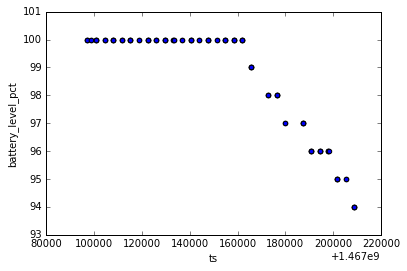

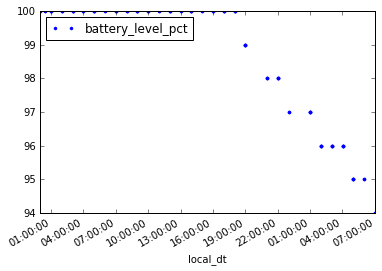

In [1613]:
#trying scatter plot with panda
tmp = iphone_battery_df_list[2]
tmp.plot(x='ts', y='battery_level_pct', kind='scatter')

xnew = tmp['metadata_write_ts'].values
local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
tmp_df = pd.DataFrame(data={'local_dt': local_dt_new, 'battery_level_pct': tmp.battery_level_pct})
tmp_df.plot(x='local_dt', y='battery_level_pct', style=".")


About to plot 0
About to plot 1
About to plot 2


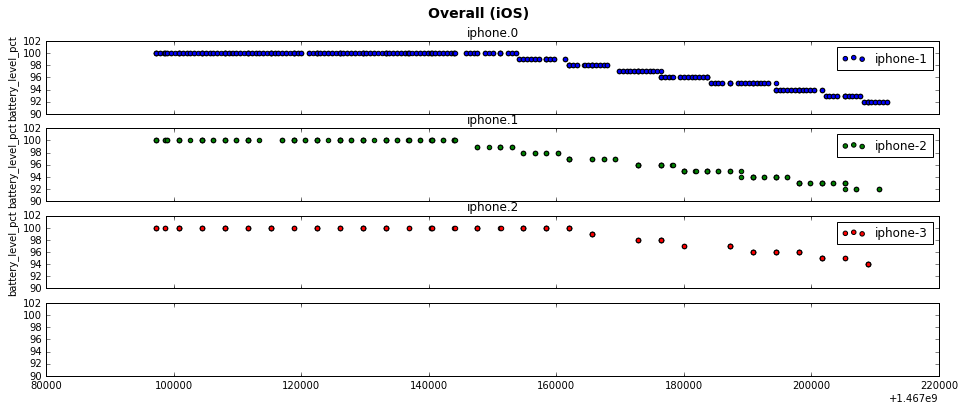

In [1620]:
#iOS: No interplation on battery data
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

afig.suptitle('Overall (iOS)', fontsize=14, fontweight='bold')
color = ['blue', 'green', 'red', 'cyan']

for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    #df.plot(x='fmt_time', y='battery_level_pct', ax=aaxes[i], style='.', title="iphone.%s" % i, label="phone-%s" % (i+1))
    df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=aaxes[i], title="iphone.%s" % i, label="iphone-%s" % (i+1), color=color[i])

About to plot 0
About to plot 1
About to plot 2


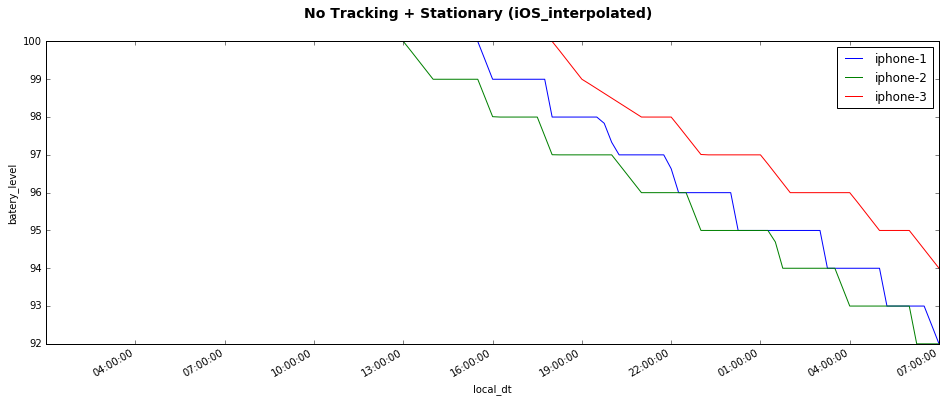

In [1621]:
#iOS: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
ifig.suptitle('No Tracking + Stationary (iOS_interpolated)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=iaxes, label="iphone-%s" % (i+1))
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=iaxes, label="iOS-%s" % i, color=color[i])
    #iaxes.set_xlabel('time')
    iaxes.set_ylabel('batery_level')

[[ 1.          0.98501177  0.98351047]
 [ 0.98501177  1.          0.96303995]
 [ 0.98351047  0.96303995  1.        ]]


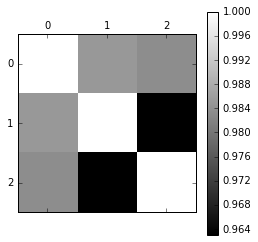

In [1622]:
#iOS
#correlation analysis (tracking_off+stationary)
#generate list of iphone battery series 
iphone_battery_series_list = map(lambda b: b.battery_level_pct, iphone_battery_interp_df_list)
print np.corrcoef(iphone_battery_series_list)
plt.matshow(np.corrcoef(iphone_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()

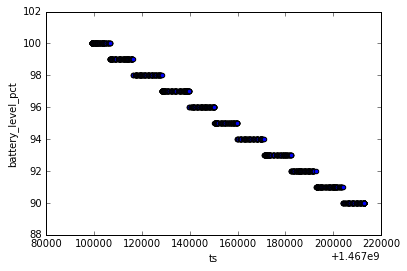

In [1623]:
first_android_df = android_battery_df_list[3]
first_android_df
first_android_df.plot(x='ts', y='battery_level_pct', kind='scatter')

4
About to plot 0
About to plot 1
About to plot 2
About to plot 3


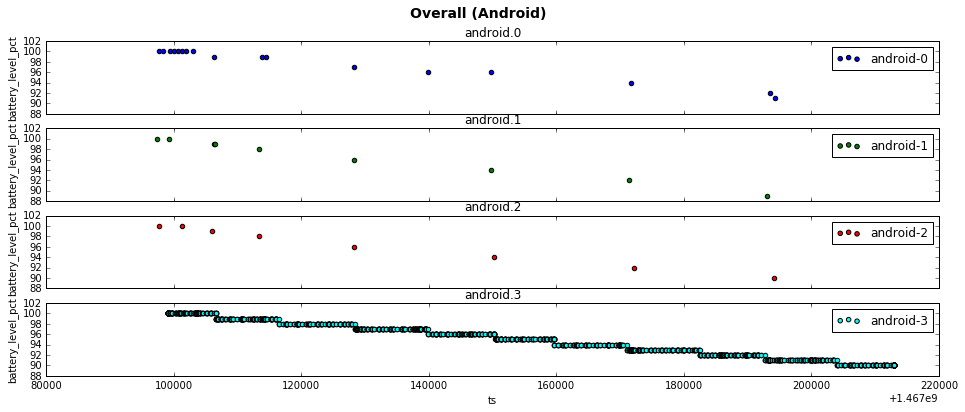

In [1628]:
#Android: No interplation on battery data 
print len(android_battery_df_list)
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

afig.suptitle('Overall (Android)', fontsize=14, fontweight='bold')
color = ['blue', 'green', 'red', 'cyan']

for i, df in enumerate(android_battery_df_list):
    print "About to plot %d" % i
    #df.plot(x='fmt_time', y='battery_level_pct', style='.', ax=aaxes[i], title="android.%s" % i, label="phone-%s" % i)
    df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=aaxes[i], title="android.%s" % i, label="android-%s" % i, color=color[i])

About to plot 0
About to plot 1
About to plot 2
About to plot 3


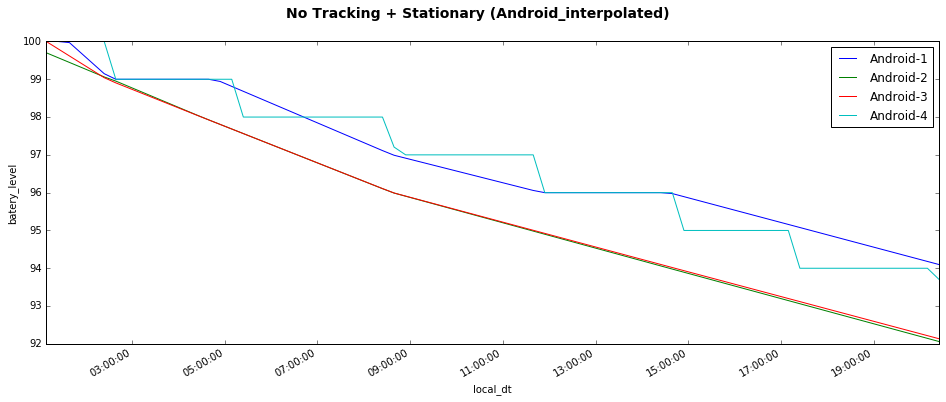

In [1629]:
#Android: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
color = ['red', 'yellow', 'blue', 'green']
ifig.suptitle('No Tracking + Stationary (Android_interpolated)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=iaxes, label="Android-%s" % (i+1))
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=iaxes, label="Android-%s" % i, color=color[i])
    #iaxes.set_xlabel('time')
    iaxes.set_ylabel('batery_level')

[[ 1.          0.99704953  0.99322639]
 [ 0.99704953  1.          0.99386446]
 [ 0.99322639  0.99386446  1.        ]]


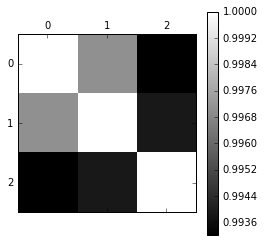

In [1553]:
#Android 
#correlation analysis(tracking_off+stationary)
#generate list of android battery series 
android_battery_series_list = map(lambda b: b.battery_level_pct, android_battery_interp_df_list)
print np.corrcoef(android_battery_series_list)
plt.matshow(np.corrcoef(android_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()